In [1]:
# import các thư viện
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# mapping
labels = {
    "Others": 0,
    "Honda": 1,
    "Suzuki": 2,
    "Yamaha": 3,
    "VinFast": 4
}
reverse_map_labels = {
    0: "Others",
    1: "Honda",
    2: "Suzuki",
    3: "Yamaha",
    4: "VinFast"
}

In [5]:
path = "/content/drive/MyDrive/Public"
output_dir = 'MotocycleDataset.csv'
d1 = []
error = pd.read_csv('/content/invalid_image_paths(1).csv')
error_paths = error.iloc[:, 0].unique().tolist()

In [6]:
def read_path(path, out_put):
    data = []
    supported_formats = ['jpg', 'png', 'jpeg']

    for label in os.listdir(path):
        if label in labels:
            y = labels[label]
            i = 0
            new_path = os.path.join(path, label)
            if os.listdir(new_path):
                for img in os.listdir(new_path):
                    if i == 1001: break
                    if any(img.lower().endswith(fmt) for fmt in supported_formats):
                        path_img = os.path.join(label, img)
                        if path_img not in error_paths:
                          data.append((path_img, int(y)))
                          i += 1

    df = pd.DataFrame(data, columns=['ImageFullPath', 'CategoryID'])
    df.to_csv(out_put, sep=',', index=False)
    return df

In [7]:
# # create file MotocycleDataset.csv
# def read_path1(path,out_put):
#   data = []
#   for label in os.listdir(path):
#     if label in labels:
#         y = labels[label]
#         new_path = os.path.join(path,label)
#         if os.listdir(new_path):
#           for img in os.listdir(new_path):
#                 type_img = img.split('.')[-1]

#                 if type_img == 'jfif' or type_img == 'webp' or type_img == 'jpe' or type_img == 'gif' or type_img == 'avif':
#                   path_img = os.path.join(label,img)
#                   d1.append(path_img)
#     #           if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
#     #             path_img = os.path.join(label,img)
#     #             data.append((path_img,int(y)))
#     # df = pd.DataFrame(data,columns = ['ImageFullPath','CategoryID'])
#     # df.to_csv(out_put, sep=',',index=False)
#     # return d1

In [8]:
a = read_path(path,output_dir)
print(len(a))

5005


So sánh thời gian đọc ảnh của pil và cv2

In [9]:
path1 = "/content/drive/MyDrive/Public"
img_path = "/content/MotocycleDataset.csv"

In [10]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

In [11]:

from zipfile import ZipFile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter


In [12]:
data = pd.read_csv(img_path)
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path1, i) for i in img]

In [13]:
len(image)

5005

In [14]:
trainX, testX, trainY, testY = train_test_split(image, label, test_size=0.3, random_state=30)
train_label_count = Counter(trainY)
test_label_count = Counter(testY)

In [15]:
testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.3, random_state=30)

In [16]:
train_label_count

Counter({3: 705, 1: 720, 2: 703, 0: 689, 4: 686})

In [17]:
test_label_count

Counter({4: 315, 1: 281, 3: 296, 2: 298, 0: 312})

In [18]:
print(len(trainX))
print(len(testX))
print(len(valX))

3503
1051
451


In [19]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [47]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, num_classes, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)  # Convert labels to numpy array
        self.num_classes = num_classes
        self.transform = transform
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]  # Retrieve label as integer

        img_cv2 = cv2.imread(img_path)
        img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
        img_pil_from_cv2 = Image.fromarray(img_cv2_rgb)

        if self.transform:
            img_pil_from_cv2 = self.transform(img_pil_from_cv2)

        # Convert image to float32
        img_pil_from_cv2 = img_pil_from_cv2.to(dtype=torch.float32)

        return img_pil_from_cv2,torch.tensor(label, dtype=torch.long)

In [48]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(384, interpolation=Image.BILINEAR),  # Resize to 384x384
        transforms.CenterCrop(384),  # Center crop to 384x384
        transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(384, interpolation=Image.BILINEAR),  # Resize to 384x384
        transforms.CenterCrop(384),  # Center crop to 384x384
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ]),
    'test': transforms.Compose([
        transforms.Resize(384, interpolation=Image.BILINEAR),  # Resize to 384x384
        transforms.CenterCrop(384),  # Center crop to 384x384
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ]),
}

In [49]:
from torch.utils.data import Dataset, DataLoader

In [50]:
train_set = CustomDataset(trainX, trainY, num_classes = 5, transform=data_transforms['train'])
val_set = CustomDataset(valX,valY, num_classes = 5, transform=data_transforms['val'])
test_set = CustomDataset(testX,testY, num_classes = 5, transform=data_transforms['test'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True,num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True,num_workers= 4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False,pin_memory=True,num_workers= 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [51]:
for i in test_loader:
  a,b = i
  print(a)
  print(b)
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([[[[-1.2959, -1.2959, -1.2959,  ...,  0.1254, -0.0287, -0.1657],
          [-1.2959, -1.2617, -1.2788,  ...,  0.2796,  0.0741, -0.0287],
          [-1.2617, -1.2445, -1.2274,  ...,  0.4508,  0.2453,  0.1083],
          ...,
          [ 0.2967,  0.1426, -0.2513,  ..., -0.3369, -0.3027, -0.3027],
          [ 0.2967,  0.2967,  0.2111,  ..., -0.3027, -0.2856, -0.2856],
          [ 0.2796,  0.2967,  0.2967,  ..., -0.3027, -0.2856, -0.2856]],

         [[-1.0203, -1.0203, -1.0203,  ..., -0.1099, -0.2500, -0.3550],
          [-0.9853, -0.9678, -0.9678,  ...,  0.0651, -0.1099, -0.1800],
          [-0.9503, -0.9328, -0.8978,  ...,  0.2402,  0.0651, -0.0399],
          ...,
          [ 0.4328,  0.2752, -0.1275,  ..., -0.1800, -0.1625, -0.1625],
          [ 0.4328,  0.4328,  0.3452,  ..., -0.1625, -0.1450, -0.1450],
          [ 0.4153,  0.4328,  0.4328,  ..., -0.1625, -0.1450, -0.1450]],

         [[-0.8110, -0.7936, -0.7936,  ..., -0.1312, -0.2532, -0.3055],
          [-0.7761, -0.7413, -

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [52]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

3503
1051


In [53]:
def show_batch_images(images, labels, mean, std, max_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Chuyển tensor từ dạng (C, H, W) sang (H, W, C)

        # Hoàn tác chuẩn hóa
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Đảm bảo giá trị nằm trong khoảng [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 hàng và 4 cột
        plt.imshow(image)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

In [54]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5,0.5,0.5])

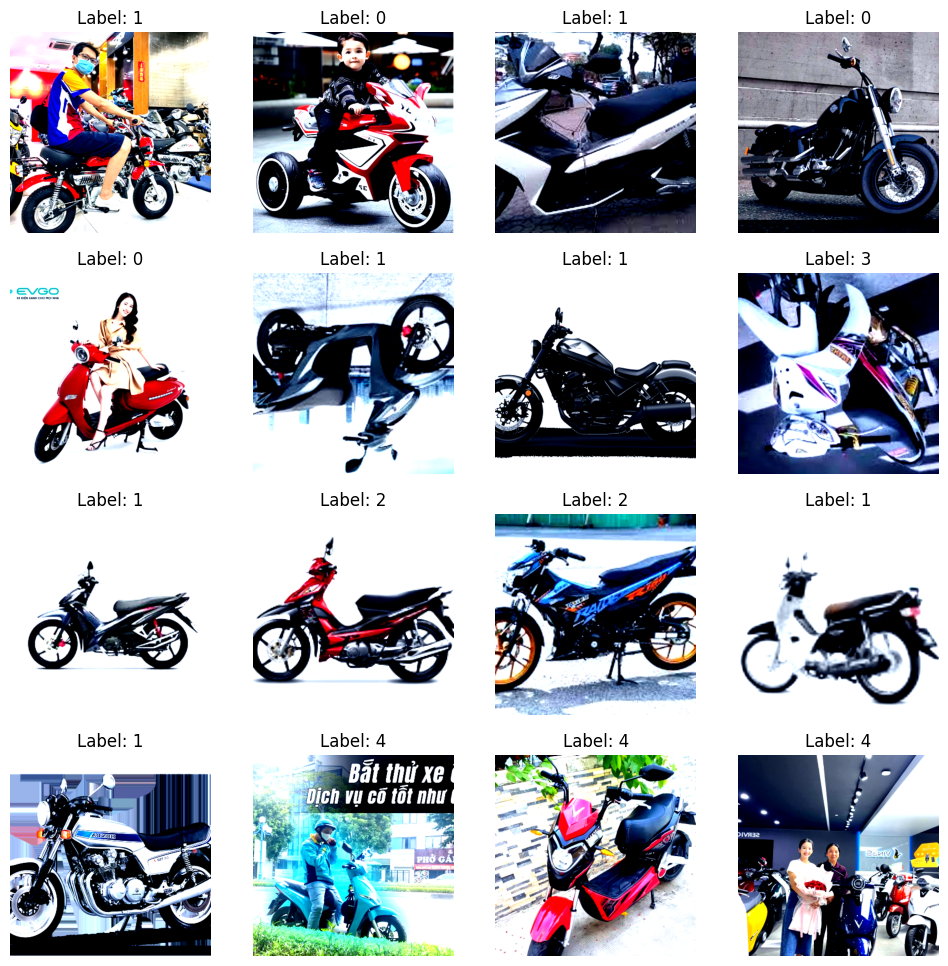

In [55]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5,0.5,0.5])

for images, labels in train_loader:
    show_batch_images(images, labels, mean, std)
    break

In [56]:

from tempfile import TemporaryDirectory
import torch.optim as optim
import time


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
device

device(type='cuda')

In [59]:
import copy

In [60]:
!pip install tqdm

In [61]:
from tqdm import tqdm

In [63]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, torch.Tensor):
        train_loss_history = train_loss_history.detach().cpu().numpy()
    if isinstance(val_loss_history, torch.Tensor):
        val_loss_history = val_loss_history.detach().cpu().numpy()
    if isinstance(train_acc_history, torch.Tensor):
        train_acc_history = train_acc_history.detach().cpu().numpy()
    if isinstance(val_acc_history, torch.Tensor):
        val_acc_history = val_acc_history.detach().cpu().numpy()

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [64]:
import torchvision.models as models
from torch.optim import lr_scheduler

In [71]:
model_ft = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

# Freeze all layers except the last fully connected layer
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last fully connected layer
for param in model_ft.classifier.parameters():  # Access the classifier directly
    param.requires_grad = True

# Replace the last fully connected layer with a new one
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(  # Replace the classifier attribute
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 5)  # Assuming you have 5 classes
)

# Move model to device (GPU if available)
model_ft = model_ft.to(device)

# Print the modified model architecture
print(model_ft)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [72]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer = optim.AdamW(model_ft.parameters(), lr=0.001, weight_decay=0.01)

# Define learning rate scheduler (decay LR by a factor of 0.1 every 7 epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [73]:
print(model_ft)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [74]:
import torch
import time
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_params_path = '/content/drive/MyDrive/bike/best_model_params1.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            image_counter = 0

            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                image_counter += len(inputs)
                if image_counter % 200 == 0:
                    print(f'Processed {image_counter} images in phase: {phase}, epoch: {epoch+1}')

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history



In [75]:
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_ft, criterion,optimizer,exp_lr_scheduler, num_epochs=15)

Epoch 1/15
------------------------------


train 1/15:   0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train 1/15:  23%|██▎       | 25/110 [02:22<11:13,  7.92s/it]

Processed 800 images in phase: train, epoch: 1


train 1/15:  45%|████▌     | 50/110 [04:13<04:20,  4.35s/it]

Processed 1600 images in phase: train, epoch: 1


train 1/15:  68%|██████▊   | 75/110 [06:05<03:06,  5.32s/it]

Processed 2400 images in phase: train, epoch: 1


train 1/15:  91%|█████████ | 100/110 [08:06<00:49,  4.94s/it]

Processed 3200 images in phase: train, epoch: 1


train 1/15: 100%|██████████| 110/110 [08:49<00:00,  3.57s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train 1/15: 100%|██████████| 110/110 [08:49<00:00,  4.81s/it]


train Loss: 1.2841 Acc: 0.4733


val 1/15: 100%|██████████| 15/15 [01:29<00:00,  5.94s/it]


val Loss: 1.0138 Acc: 0.6120

Epoch 2/15
------------------------------


train 2/15:  23%|██▎       | 25/110 [00:50<02:04,  1.46s/it]

Processed 800 images in phase: train, epoch: 2


train 2/15:  45%|████▌     | 50/110 [01:25<01:06,  1.11s/it]

Processed 1600 images in phase: train, epoch: 2


train 2/15:  67%|██████▋   | 74/110 [02:00<01:17,  2.16s/it]

Processed 2400 images in phase: train, epoch: 2


train 2/15:  91%|█████████ | 100/110 [02:45<00:30,  3.02s/it]

Processed 3200 images in phase: train, epoch: 2


train 2/15: 100%|██████████| 110/110 [02:53<00:00,  1.58s/it]


train Loss: 1.0170 Acc: 0.6021


val 2/15: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


val Loss: 0.9302 Acc: 0.6475

Epoch 3/15
------------------------------


train 3/15:  23%|██▎       | 25/110 [00:47<02:47,  1.97s/it]

Processed 800 images in phase: train, epoch: 3


train 3/15:  45%|████▌     | 50/110 [01:27<01:39,  1.66s/it]

Processed 1600 images in phase: train, epoch: 3


train 3/15:  68%|██████▊   | 75/110 [02:08<00:57,  1.63s/it]

Processed 2400 images in phase: train, epoch: 3


train 3/15:  91%|█████████ | 100/110 [02:43<00:12,  1.26s/it]

Processed 3200 images in phase: train, epoch: 3


train 3/15: 100%|██████████| 110/110 [02:52<00:00,  1.57s/it]


train Loss: 0.8904 Acc: 0.6674


val 3/15: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


val Loss: 0.8687 Acc: 0.6829

Epoch 4/15
------------------------------


train 4/15:  23%|██▎       | 25/110 [00:46<01:43,  1.22s/it]

Processed 800 images in phase: train, epoch: 4


train 4/15:  45%|████▌     | 50/110 [01:29<01:17,  1.30s/it]

Processed 1600 images in phase: train, epoch: 4


train 4/15:  68%|██████▊   | 75/110 [02:03<00:26,  1.34it/s]

Processed 2400 images in phase: train, epoch: 4


train 4/15:  90%|█████████ | 99/110 [02:46<00:07,  1.42it/s]

Processed 3200 images in phase: train, epoch: 4


train 4/15: 100%|██████████| 110/110 [02:58<00:00,  1.62s/it]


train Loss: 0.8109 Acc: 0.6954


val 4/15: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


val Loss: 0.8565 Acc: 0.6918

Epoch 5/15
------------------------------


train 5/15:  22%|██▏       | 24/110 [00:45<02:13,  1.56s/it]

Processed 800 images in phase: train, epoch: 5


train 5/15:  45%|████▌     | 50/110 [01:30<00:46,  1.28it/s]

Processed 1600 images in phase: train, epoch: 5


train 5/15:  68%|██████▊   | 75/110 [02:12<01:45,  3.00s/it]

Processed 2400 images in phase: train, epoch: 5


train 5/15:  90%|█████████ | 99/110 [02:41<00:18,  1.66s/it]

Processed 3200 images in phase: train, epoch: 5


train 5/15: 100%|██████████| 110/110 [02:52<00:00,  1.57s/it]


train Loss: 0.7456 Acc: 0.7245


val 5/15: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


val Loss: 0.8540 Acc: 0.6741

Epoch 6/15
------------------------------


train 6/15:  23%|██▎       | 25/110 [00:41<01:03,  1.34it/s]

Processed 800 images in phase: train, epoch: 6


train 6/15:  45%|████▍     | 49/110 [01:26<02:14,  2.20s/it]

Processed 1600 images in phase: train, epoch: 6


train 6/15:  67%|██████▋   | 74/110 [02:05<00:57,  1.61s/it]

Processed 2400 images in phase: train, epoch: 6


train 6/15:  90%|█████████ | 99/110 [02:40<00:09,  1.13it/s]

Processed 3200 images in phase: train, epoch: 6


train 6/15: 100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


train Loss: 0.6296 Acc: 0.7679


val 6/15: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


val Loss: 0.7956 Acc: 0.6918

Epoch 7/15
------------------------------


train 7/15:  23%|██▎       | 25/110 [00:50<01:38,  1.16s/it]

Processed 800 images in phase: train, epoch: 7


train 7/15:  45%|████▌     | 50/110 [01:32<01:57,  1.95s/it]

Processed 1600 images in phase: train, epoch: 7


train 7/15:  67%|██████▋   | 74/110 [01:59<00:50,  1.41s/it]

Processed 2400 images in phase: train, epoch: 7


train 7/15:  91%|█████████ | 100/110 [02:42<00:13,  1.39s/it]

Processed 3200 images in phase: train, epoch: 7


train 7/15: 100%|██████████| 110/110 [02:51<00:00,  1.56s/it]


train Loss: 0.6037 Acc: 0.7876


val 7/15: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


val Loss: 0.7569 Acc: 0.7162

Epoch 8/15
------------------------------


train 8/15:  23%|██▎       | 25/110 [00:47<01:52,  1.33s/it]

Processed 800 images in phase: train, epoch: 8


train 8/15:  45%|████▌     | 50/110 [01:21<00:46,  1.30it/s]

Processed 1600 images in phase: train, epoch: 8


train 8/15:  68%|██████▊   | 75/110 [01:54<00:22,  1.57it/s]

Processed 2400 images in phase: train, epoch: 8


train 8/15:  90%|█████████ | 99/110 [02:44<00:29,  2.70s/it]

Processed 3200 images in phase: train, epoch: 8


train 8/15: 100%|██████████| 110/110 [02:57<00:00,  1.61s/it]


train Loss: 0.5771 Acc: 0.7996


val 8/15: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


val Loss: 0.7578 Acc: 0.7251

Epoch 9/15
------------------------------


train 9/15:  22%|██▏       | 24/110 [00:38<01:52,  1.31s/it]

Processed 800 images in phase: train, epoch: 9


train 9/15:  45%|████▌     | 50/110 [01:24<03:07,  3.13s/it]

Processed 1600 images in phase: train, epoch: 9


train 9/15:  68%|██████▊   | 75/110 [02:03<00:31,  1.10it/s]

Processed 2400 images in phase: train, epoch: 9


train 9/15:  91%|█████████ | 100/110 [02:43<00:26,  2.65s/it]

Processed 3200 images in phase: train, epoch: 9


train 9/15: 100%|██████████| 110/110 [02:50<00:00,  1.55s/it]


train Loss: 0.5279 Acc: 0.8142


val 9/15: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


val Loss: 0.7380 Acc: 0.7228

Epoch 10/15
------------------------------


train 10/15:  23%|██▎       | 25/110 [00:47<02:48,  1.98s/it]

Processed 800 images in phase: train, epoch: 10


train 10/15:  45%|████▌     | 50/110 [01:23<02:21,  2.35s/it]

Processed 1600 images in phase: train, epoch: 10


train 10/15:  67%|██████▋   | 74/110 [01:55<01:01,  1.71s/it]

Processed 2400 images in phase: train, epoch: 10


train 10/15:  90%|█████████ | 99/110 [02:38<00:17,  1.64s/it]

Processed 3200 images in phase: train, epoch: 10


train 10/15: 100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


train Loss: 0.5077 Acc: 0.8187


val 10/15: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


val Loss: 0.7321 Acc: 0.7317

Epoch 11/15
------------------------------


train 11/15:  23%|██▎       | 25/110 [00:39<02:07,  1.50s/it]

Processed 800 images in phase: train, epoch: 11


train 11/15:  45%|████▍     | 49/110 [01:17<01:41,  1.67s/it]

Processed 1600 images in phase: train, epoch: 11


train 11/15:  68%|██████▊   | 75/110 [02:02<00:49,  1.42s/it]

Processed 2400 images in phase: train, epoch: 11


train 11/15:  91%|█████████ | 100/110 [02:38<00:08,  1.12it/s]

Processed 3200 images in phase: train, epoch: 11


train 11/15: 100%|██████████| 110/110 [02:52<00:00,  1.57s/it]


train Loss: 0.5026 Acc: 0.8333


val 11/15: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


val Loss: 0.7391 Acc: 0.7206

Epoch 12/15
------------------------------


train 12/15:  22%|██▏       | 24/110 [00:42<02:48,  1.96s/it]

Processed 800 images in phase: train, epoch: 12


train 12/15:  45%|████▌     | 50/110 [01:17<00:53,  1.12it/s]

Processed 1600 images in phase: train, epoch: 12


train 12/15:  67%|██████▋   | 74/110 [01:54<00:39,  1.10s/it]

Processed 2400 images in phase: train, epoch: 12


train 12/15:  90%|█████████ | 99/110 [02:36<00:31,  2.85s/it]

Processed 3200 images in phase: train, epoch: 12


train 12/15: 100%|██████████| 110/110 [02:49<00:00,  1.54s/it]


train Loss: 0.4984 Acc: 0.8279


val 12/15: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


val Loss: 0.7375 Acc: 0.7251

Epoch 13/15
------------------------------


train 13/15:  23%|██▎       | 25/110 [00:39<02:05,  1.48s/it]

Processed 800 images in phase: train, epoch: 13


train 13/15:  45%|████▌     | 50/110 [01:17<01:10,  1.17s/it]

Processed 1600 images in phase: train, epoch: 13


train 13/15:  67%|██████▋   | 74/110 [01:55<00:59,  1.65s/it]

Processed 2400 images in phase: train, epoch: 13


train 13/15:  90%|█████████ | 99/110 [02:39<00:13,  1.26s/it]

Processed 3200 images in phase: train, epoch: 13


train 13/15: 100%|██████████| 110/110 [02:50<00:00,  1.55s/it]


train Loss: 0.4906 Acc: 0.8361


val 13/15: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


val Loss: 0.7286 Acc: 0.7494

Epoch 14/15
------------------------------


train 14/15:  23%|██▎       | 25/110 [00:38<01:17,  1.10it/s]

Processed 800 images in phase: train, epoch: 14


train 14/15:  45%|████▌     | 50/110 [01:21<01:27,  1.46s/it]

Processed 1600 images in phase: train, epoch: 14


train 14/15:  67%|██████▋   | 74/110 [02:02<01:24,  2.36s/it]

Processed 2400 images in phase: train, epoch: 14


train 14/15:  91%|█████████ | 100/110 [02:53<00:14,  1.42s/it]

Processed 3200 images in phase: train, epoch: 14


train 14/15: 100%|██████████| 110/110 [03:01<00:00,  1.65s/it]


train Loss: 0.4914 Acc: 0.8310


val 14/15: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


val Loss: 0.7354 Acc: 0.7251

Epoch 15/15
------------------------------


train 15/15:  23%|██▎       | 25/110 [00:39<01:53,  1.33s/it]

Processed 800 images in phase: train, epoch: 15


train 15/15:  45%|████▌     | 50/110 [01:20<02:03,  2.05s/it]

Processed 1600 images in phase: train, epoch: 15


train 15/15:  68%|██████▊   | 75/110 [02:01<00:44,  1.26s/it]

Processed 2400 images in phase: train, epoch: 15


train 15/15:  91%|█████████ | 100/110 [02:40<00:09,  1.07it/s]

Processed 3200 images in phase: train, epoch: 15


train 15/15: 100%|██████████| 110/110 [02:52<00:00,  1.57s/it]


train Loss: 0.4975 Acc: 0.8250


val 15/15: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


val Loss: 0.7298 Acc: 0.7450

Training complete in 56m 7s
Best val Acc: 0.7494


In [76]:
def plot_training_history1(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, torch.Tensor):
        train_loss_history = train_loss_history.detach().cpu().numpy()
    if isinstance(val_loss_history, torch.Tensor):
        val_loss_history = val_loss_history.detach().cpu().numpy()
    if isinstance(train_acc_history, torch.Tensor):
        train_acc_history = train_acc_history.detach().cpu().numpy() # Move tensor to CPU and convert to NumPy
    if isinstance(val_acc_history, torch.Tensor):
        val_acc_history = val_acc_history.detach().cpu().numpy() # Move tensor to CPU and convert to NumPy

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [77]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

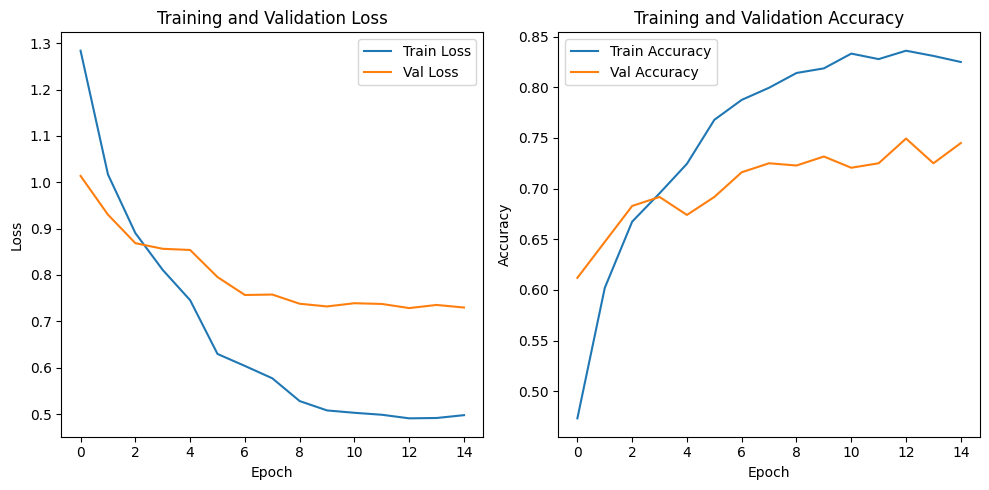

In [78]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

eval

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 0.7069


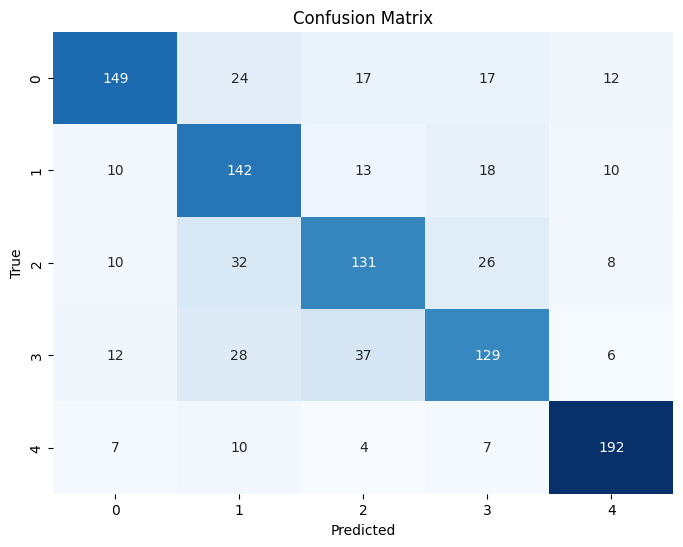

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_ft.eval()

predictions = []
true_labels = []
with torch.no_grad():
# Iterate over test loader
  for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model_ft(inputs)
      _, preds = torch.max(outputs, 1)

      # Append predictions and true labels
      predictions.extend(preds.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def preprocess_image(image_path):
    """Load and preprocess an image."""
    # Define the transforms
    transform = transforms.Compose([
        transforms.Resize(384, interpolation=Image.BILINEAR),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transforms
    image = transform(image)

    # Add batch dimension
    image = image.unsqueeze(0)

    return image

def predict_single_image(image_path, model, device):
    """Predict the class of a single image using the trained model."""
    # Preprocess the image
    image = preprocess_image(image_path)

    # Move the image to the device
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # Forward pass
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return preds.item()

# Path to the image you want to test
image_path = 'path_to_your_image.jpg'

# Predict the class of the image
predicted_class = predict_single_image(image_path, model_ft, device)

# Print the predicted class
print(f'The predicted class for the image is: {predicted_class}')